# Load Data

In [1]:
dt = 1/60 # fps
delay = 0.083 # s
T = 50  # frames selected for STA

In [2]:
import datajoint as dj
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import pickle

res_file = r"080124B_results.mat"
f = h5py.File(res_file)

for cell in f['results']['NaturalMovingObject'][1,:]:

    if len(f[cell]) < 63:
        continue

    trajx_n = []    
    trajy_n = []    
    trajx_c = []    
    trajy_c = []    
    spike_indices_n = []
    spike_indices_c = []
    
    for cx,cy,si,t in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['motion_trajectory'][0,:]):
        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'natural':
            trajx_n.extend(f[cx][:])
            trajy_n.extend(f[cy][:])
            spike_indices_n.append(f[si][:])
        else:
            trajx_c.extend(f[cx][:])
            trajy_c.extend(f[cy][:])
            spike_indices_c.append(f[si][:])
    break # only use the first cell, for this example


for cell in f['results']['SpotField'][1,:]:
    trajx_SF30 = []    
    trajy_SF30 = []    
    spike_indices_SF30 = [] 
    trajx_SF15 = []    
    trajy_SF15 = []
    spike_indices_SF15 = []

    for cx,cy,si,ss in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['spot_size'][0,:]):
        if f[ss][()]==30:
            trajx_SF30.extend(f[cx][:].transpose()+15)
            trajy_SF30.extend(f[cy][:].transpose()-25)
            spike_indices_SF30.append(f[si][:])
        else:
            trajx_SF15.extend(f[cx][:].transpose()+15)
            trajy_SF15.extend(f[cy][:].transpose()-25)
            spike_indices_SF15.append(f[si][:])
    break # only use the first cell

for cell in f['results']['MovingObject'][1,:]:
    v_M = []
    direc_M = []   
    spike_indices_M = []
    center_time_shift = []
    for speed,direction,si,ct in zip(f[cell]['speed'][0,:], f[cell]['direction'][0,:], f[cell]['spike_indices'][0,:],f[cell]['center_time_shift'][0,:]):
        v_M.extend(f[speed][:])
        direc_M.extend(f[direction][:])
        spike_indices_M.append(f[si][:])
        center_time_shift.append(f[ct][:])

    break # only use the first cell

In [3]:
with open('spike_indices_n.pkl', 'wb') as f:
    pickle.dump(spike_indices_n, f)
with open('spike_indices_c.pkl', 'wb') as f:
    pickle.dump(spike_indices_c, f)
    

In [4]:

epochD = (15+15+45)/60 *10000# 1/10000 s
binsSF = np.arange(0, epochD*29, epochD) 
spikecountsSF = []
for i in range(len(spike_indices_SF15)):
    countstem, bin_edgesSF = np.histogram(spike_indices_SF15[i], bins=binsSF)
    spikecountsSF.append(countstem)

In [5]:

total_time = 0.05+0.05+0.8
time_steps_M = int(total_time / dt)  
trajx_M = []    
trajy_M = []    

# Loop through trials
for trial_idx in range(len(v_M)):

    v_trial = v_M[trial_idx] 
    direc_trial = direc_M[trial_idx]  
    center_time_shift_trail = center_time_shift[trial_idx] /1000

    theta = np.radians(direc_trial)
    
    

    start_x = - (v_trial * np.cos(theta) * (total_time/2+center_time_shift_trail))
    start_y = - (v_trial * np.sin(theta) * (total_time/2+center_time_shift_trail))


    traj_x_trail = [start_x]
    traj_y_trail = [start_y]
    
    for t in range(time_steps_M):  
        dx = v_trial * np.cos(theta) * (1 / 60)  
        dy = v_trial * np.sin(theta) * (1 / 60)  
        traj_x_trail.append(traj_x_trail[-1] + dx)  
        traj_y_trail.append(traj_y_trail[-1] + dy)  


    traj_x_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0
    traj_y_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0
    trajx_M.append(traj_x_trail)
    trajy_M.append(traj_y_trail)


trajx_n = np.asarray(trajx_n)
trajy_n = np.asarray(trajy_n)
trajx_c = np.asarray(trajx_c)
trajy_c = np.asarray(trajy_c)
trajx_M = np.array(trajx_M)  # Shape: (192, 55)
trajy_M = np.array(trajy_M)  # Shape: (192, 55)
trajx_M = np.squeeze(trajx_M) 
trajy_M = np.squeeze(trajy_M)

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_34472\3690897418.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  traj_x_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_34472\3690897418.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  traj_y_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0


# Spike Raster

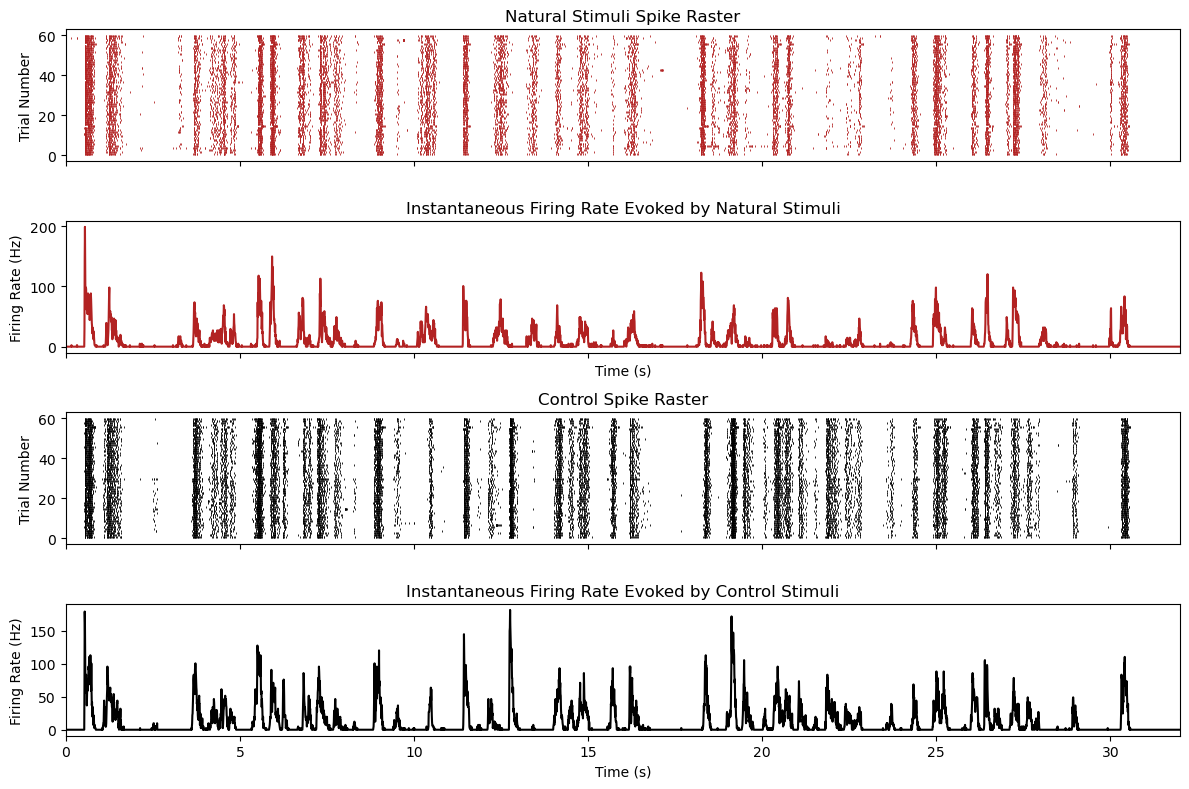

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

num_trials_n = len(spike_indices_n)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices_n[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=0.6)
spikes_n = np.array(spikes_n)
ISI_n = np.mean(np.diff(spikes_n.flatten()))




spikes_c = []
num_trials_c = len(spike_indices_c)
for spike_idx_c in range(num_trials_c):
    spikes_in_trial = spike_indices_c[spike_idx_c] / 10000 - delay
    spikes_c.extend(spikes_in_trial)
    ax3.vlines(spikes_in_trial, spike_idx_c, spike_idx_c + 1, 'k', linewidth=0.6)


spikes_c = np.array(spikes_c)
ISI_c = np.mean(np.diff(spikes_c.flatten()))


minISI = min(ISI_c,ISI_n)

bin_width = 5 * minISI # s
bins = np.arange(0, 32 + bin_width, bin_width) 
counts_n, bin_edges = np.histogram(spikes_n, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax1.set_ylabel('Trial Number')
ax1.set_title('Natural Stimuli Spike Raster')
ax1.set_xlim(0, 32)  

average_spike_count_n = counts_n / num_trials_n
firing_rate_n = average_spike_count_n / bin_width

ax2.plot(bin_centers, firing_rate_n, 'firebrick')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli')


ax3.set_ylabel('Trial Number')
ax3.set_title('Control Spike Raster')
ax3.set_xlim(0, 32)  

counts_c, bin_edges = np.histogram(spikes_c, bins=bins)
average_spike_count_c = counts_c / num_trials_c
firing_rate_c = average_spike_count_c / bin_width
ax4.plot(bin_centers, firing_rate_c, 'k')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Firing Rate (Hz)')
ax4.set_title('Instantaneous Firing Rate Evoked by Control Stimuli')

plt.tight_layout()
plt.show()

# STA

In [7]:

all_vc = []
all_ac = []
all_r_c = []


for trial_idx in range(len(trajx_c)):
    dpc_x = np.diff(trajx_c[trial_idx])
    dpc_y = np.diff(trajy_c[trial_idx])
    vc_x = dpc_x / dt
    vc_y = dpc_y / dt
    vc = np.sqrt(vc_x**2 + vc_y**2)
    dvc_x = np.diff(vc_x)
    dvc_y = np.diff(vc_y)
    ac_x = dvc_x / dt
    ac_y = dvc_y / dt
    ac = np.sqrt(ac_x**2 + ac_y**2)
    r_c = np.sqrt(trajx_c[trial_idx]**2 + trajy_c[trial_idx]**2)
    
    all_vc.append(vc)
    all_ac.append(ac)
    all_r_c.append(r_c)
    
all_vc = np.array(all_vc) 
all_ac = np.array(all_ac)
all_r_c = np.array(all_r_c)



all_vn = []
all_an = []
all_r_n = []



for trial_idx in range(len(trajx_n)):
    dpn_x = np.diff(trajx_n[trial_idx])
    dpn_y = np.diff(trajy_n[trial_idx])
    vn_x = dpn_x / dt
    vn_y = dpn_y / dt
    vn = np.sqrt(vn_x**2 + vn_y**2)
    dvn_x = np.diff(vn_x)
    dvn_y = np.diff(vn_y)
    an_x = dvn_x / dt
    an_y = dvn_y / dt
    an = np.sqrt(an_x**2 + an_y**2)
    r_n = np.sqrt(trajx_n[trial_idx]**2 + trajy_n[trial_idx]**2)
    
    all_vn.append(vn)
    all_an.append(an)
    all_r_n.append(r_n)



all_vn = np.array(all_vn)
all_an = np.array(all_an)
all_r_n = np.array(all_r_n)


mean_vc = np.nanmean(all_vc)  
mean_ac = np.nanmean(all_ac)

mean_vn = np.nanmean(all_vn)  
mean_an = np.nanmean(all_an)

all_vc_centered = all_vc - mean_vc
all_ac_centered = all_ac - mean_ac

all_vn_centered = all_vn - mean_vn
all_an_centered = all_an - mean_an
all_vc -= mean_vc
all_ac -= mean_ac
all_vn -= mean_vn
all_an -= mean_an

In [8]:

time_window = np.linspace(-T * dt, -dt, T)

d_n = np.zeros((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])))

d_c = np.zeros((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])))

sta_v_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_a_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_x_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_y_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_r_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)

sta_v_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_a_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_x_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_y_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_r_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)

for trial_idx, spikes in enumerate(spike_indices_n):
    spike_indices = (spikes.flatten() / 10000 / dt).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n[max(-i0, 0):, trial_idx, spike_idx] += 1


for trial_idx, spikes in enumerate(spike_indices_c):
    spike_indices = (spikes.flatten() / 10000 / dt).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_c[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vc[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_c[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_ac[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_c[max(-i0, 0):, trial_idx, spike_idx] = trajx_c[trial_idx][max(i0, 0):si]
        sta_y_c[max(-i0, 0):, trial_idx, spike_idx] = trajy_c[trial_idx][max(i0, 0):si]
        sta_r_c[max(-i0, 0):, trial_idx, spike_idx] = all_r_c[trial_idx][max(i0, 0):si]
        d_c[max(-i0, 0):, trial_idx, spike_idx] += 1

sta_v_n /= d_n
sta_a_n /= d_n
sta_x_n /= d_n
sta_y_n /= d_n
sta_r_n /= d_n

sta_v_c /= d_c
sta_a_c /= d_c
sta_x_c /= d_c
sta_y_c /= d_c
sta_r_c /= d_c


avg_sta_v_n = np.nanmean(sta_v_n, axis=(1, 2))
avg_sta_a_n = np.nanmean(sta_a_n, axis=(1, 2))
avg_sta_x_n = np.nanmean(sta_x_n, axis=(1, 2))
avg_sta_y_n = np.nanmean(sta_y_n, axis=(1, 2))
avg_sta_r_n = np.nanmean(sta_r_n, axis=(1, 2))

avg_sta_v_c = np.nanmean(sta_v_c, axis=(1, 2))
avg_sta_a_c = np.nanmean(sta_a_c, axis=(1, 2))
avg_sta_x_c = np.nanmean(sta_x_c, axis=(1, 2))
avg_sta_y_c = np.nanmean(sta_y_c, axis=(1, 2))
avg_sta_r_c = np.nanmean(sta_r_c, axis=(1, 2))


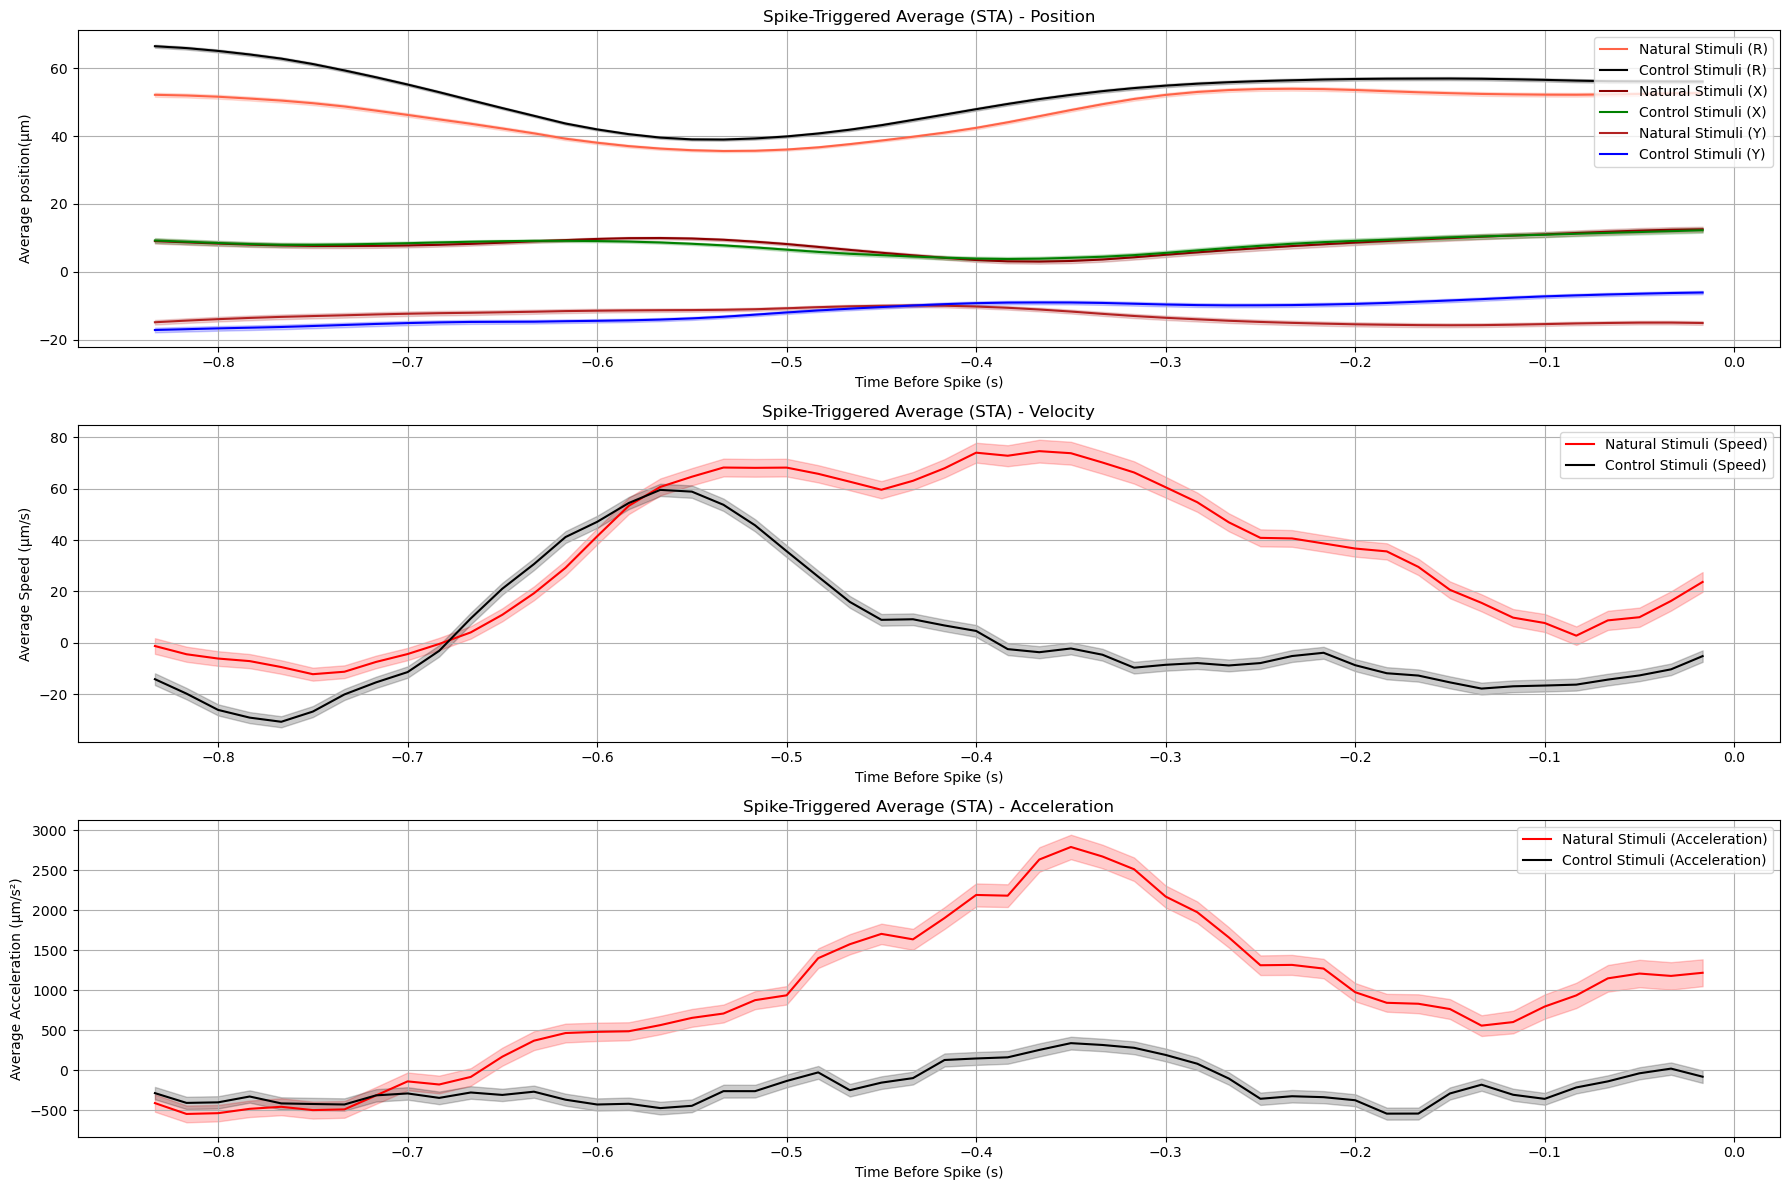

In [9]:
# Plot STA for velocity and acceleration
time_window = np.linspace(-T * dt, -dt, T)

sem_x_n = np.nanstd(sta_x_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_x_c = np.nanstd(sta_x_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))
sem_y_n = np.nanstd(sta_y_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_y_c = np.nanstd(sta_y_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))
sem_r_n = np.nanstd(sta_r_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_r_c = np.nanstd(sta_r_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))


sem_v_n = np.nanstd(sta_v_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_v_c = np.nanstd(sta_v_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))

sem_a_n = np.nanstd(sta_a_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_a_c = np.nanstd(sta_a_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))

plt.figure(figsize=(18, 12))

# Position
plt.subplot(3, 1, 1)
plt.plot(time_window, avg_sta_r_n, label='Natural Stimuli (R)', color='tomato')
plt.fill_between(time_window,  avg_sta_r_n - 2 * sem_r_n,  avg_sta_r_n + 2 * sem_r_n,color='tomato', alpha=0.2)
plt.plot(time_window, avg_sta_r_c, label='Control Stimuli (R)', color='k')
plt.fill_between(time_window,  avg_sta_r_c - 2 * sem_r_c,  avg_sta_r_c + 2 * sem_r_c,color='k', alpha=0.2)
plt.plot(time_window, avg_sta_x_n, label='Natural Stimuli (X)', color='darkred')
plt.fill_between(time_window,  avg_sta_x_n - 2 * sem_x_n,  avg_sta_x_n + 2 * sem_x_n,color='darkred', alpha=0.2)
plt.plot(time_window, avg_sta_x_c, label='Control Stimuli (X)', color='green')
plt.fill_between(time_window,  avg_sta_x_c - 2 * sem_x_c,  avg_sta_x_c + 2 * sem_x_c,color='green', alpha=0.2)
plt.plot(time_window, avg_sta_y_n, label='Natural Stimuli (Y)', color='firebrick')
plt.fill_between(time_window,  avg_sta_y_n - 2 * sem_y_n,  avg_sta_y_n + 2 * sem_y_n,color='firebrick', alpha=0.2)
plt.plot(time_window, avg_sta_y_c, label='Control Stimuli (Y)', color='blue')
plt.fill_between(time_window,  avg_sta_y_c - 2 * sem_y_c,  avg_sta_y_c + 2 * sem_y_c,color='blue', alpha=0.2)

plt.xlabel('Time Before Spike (s)')
plt.ylabel('Average position(μm)')
plt.title('Spike-Triggered Average (STA) - Position')
plt.legend()
plt.grid(True)

# Velocity
plt.subplot(3, 1, 2)
plt.plot(time_window, avg_sta_v_n, label='Natural Stimuli (Speed)', color='red')
plt.fill_between(time_window,  avg_sta_v_n - 2 * sem_v_n,  avg_sta_v_n + 2 * sem_v_n,color='red', alpha=0.2)
plt.plot(time_window, avg_sta_v_c, label='Control Stimuli (Speed)', color='k')
plt.fill_between(time_window,  avg_sta_v_c - 2 * sem_v_c,  avg_sta_v_c + 2 * sem_v_c,color='k', alpha=0.2)
plt.xlabel('Time Before Spike (s)')
plt.ylabel('Average Speed (μm/s)')
plt.title('Spike-Triggered Average (STA) - Velocity')
plt.legend()
plt.grid(True)

# Acceleration
plt.subplot(3, 1, 3)
plt.plot(time_window, avg_sta_a_n, label='Natural Stimuli (Acceleration)', color='red')
plt.fill_between(time_window,  avg_sta_a_n - 2 * sem_a_n, avg_sta_a_n + 2 * sem_a_n,color='red', alpha=0.2)
plt.plot(time_window, avg_sta_a_c, label='Control Stimuli (Acceleration)', color='k')
plt.fill_between(time_window, avg_sta_a_c - 2 * sem_a_c, avg_sta_a_c + 2 * sem_a_c,color='k', alpha=0.2)
plt.xlabel('Time Before Spike (s)')
plt.ylabel('Average Acceleration (μm/s²)')
plt.title('Spike-Triggered Average (STA) - Acceleration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# LN-GC model

# stimuli generation

In [10]:
import stimgenerate as sg
stimuli_n = sg.generate_stimuli(trajx_n[0][0:1800], trajy_n[0][0:1800],board_size=400, diameter=30,fps = 60,pretime = 500,tailtime =500,type='natural',preframes=15,tailframes=45,stimframes=15)  
stimuli_c = sg.generate_stimuli(trajx_c[0][0:1800], trajy_c[0][0:1800],board_size=400, diameter=30,fps = 60,pretime = 500,tailtime =500,type='natural',preframes=15,tailframes=45,stimframes=15)  
stimuli_M = []
for moving_trialidx in range(len(v_M)):
    stimuli_M.append(sg.generate_stimuli(trajx_M[moving_trialidx], trajy_M[moving_trialidx],400,30,60,50,50)) 
print(f"Generated stimuli shape: {stimuli_n.shape}")

Generated stimuli shape: (1860, 401, 401)


In [11]:
np.save('stimuli_n.npy', stimuli_n)
np.save('stimuli_c.npy', stimuli_c)

# Linear filter

In [12]:
def spatial_filterSF(rf,A=0.2):

    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=0.2, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))


def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround

def biphasic_temporal_filter(t, 
                             t_neg=40, t_pos=400, t_peak=120, 
                             sigma_neg=18, sigma_pos=56,
                             rel_ampli=1):
    t_shifted = t - t[0]

    # Negative phase
    negative_phase = - (t_shifted / t_neg) \
                     * np.exp(-((t_shifted - t_neg)**2)/(2*sigma_neg**2))

    # Positive phase
    positive_phase =  (t_shifted / t_pos) \
                     * np.exp(-((t_shifted - t_peak)**2)/(2*sigma_pos**2))

    temporal_filter = rel_ampli*negative_phase + (positive_phase)

    # Normalize so the max abs value is 1
    temporal_filter /= np.max(np.abs(temporal_filter))
    return temporal_filter

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s , noise_input, temporal_filter, type,rf_estimated):   

    T, Y, X = noise_input.shape 
    x = np.linspace(-(X-1)/2, (X-1)/2, X)
    y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    if type == 'gaussian':
        spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    if type == 'difference_of_gaussians':
        spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    if type == 'SFfitting':
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie


In [13]:
def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate / (1 + np.exp(-gain * (linear_output+C))) 
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    


In [14]:
#animation = animate_stimuli(stimuli_SF15[0], x_range=[-200, 200], y_range=[-200, 200], filename="stimuli_SF_60fpsaltered.html")

# Gain control definition

In [15]:
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


# Parameter settting for model

In [17]:
temporal_filter_noise = np.load('temporal_filter2.npy')
# optimal parameters
# 4 for linear and gain control
# A, multiply the spatial filter
# B, gain control strength
# tau, gain control time window
# pnratio, represents the ratio btw negative part and positive part of temporal filter
# 3 parameters for a sigmoid plus threshold non linear filter

theta = 30
A     = 0.8923 
B     = 0.000505 
tau   = 8.13 
pnratio = 0.631 
gain = 0.00213
max_rate = 200
y = -800



In [18]:

stimttype = 'natural'
if stimttype == 'natural':
    stimuli = stimuli_n 
    t_sampling = np.linspace(0,1860,1860)
if stimttype == 'control':
    stimuli = stimuli_c
    t_sampling = np.linspace(0,1860,1860)
if stimttype == 'movingobject':
    moving_trialidx = 10
    stimuli = stimuli_M[moving_trialidx]
    t_sampling = np.linspace(0,55,55)

rf_estimated = np.load('rf_estimated.npy')

time_para = 5400 # time bin to generate spike
num_modeltrails = 60 #
# temporal filter 
t_temporal = np.linspace(-500, 0, 30) 
t_temporalfitted = np.linspace(-2000/3,0, 40) 
temp_rf = biphasic_temporal_filter(t_temporal, t_neg=60,t_pos=100, t_peak=400, sigma_neg=90, sigma_pos=20,rel_ampli=0.6)
reversed_temp_rf = temporal_filter_noise[::-1]
reversed_temp_rf[8:] = reversed_temp_rf[8:]*pnratio


# spatial filter (gussian
spatialtype = 'SFfitting'
sigma_x, sigma_y = 70,70   #normal
sigma_c, sigma_s = 70, 140  #diff
A_c=0.4 # center
A_s=0.2 # surround


# Spatial Filter Fig

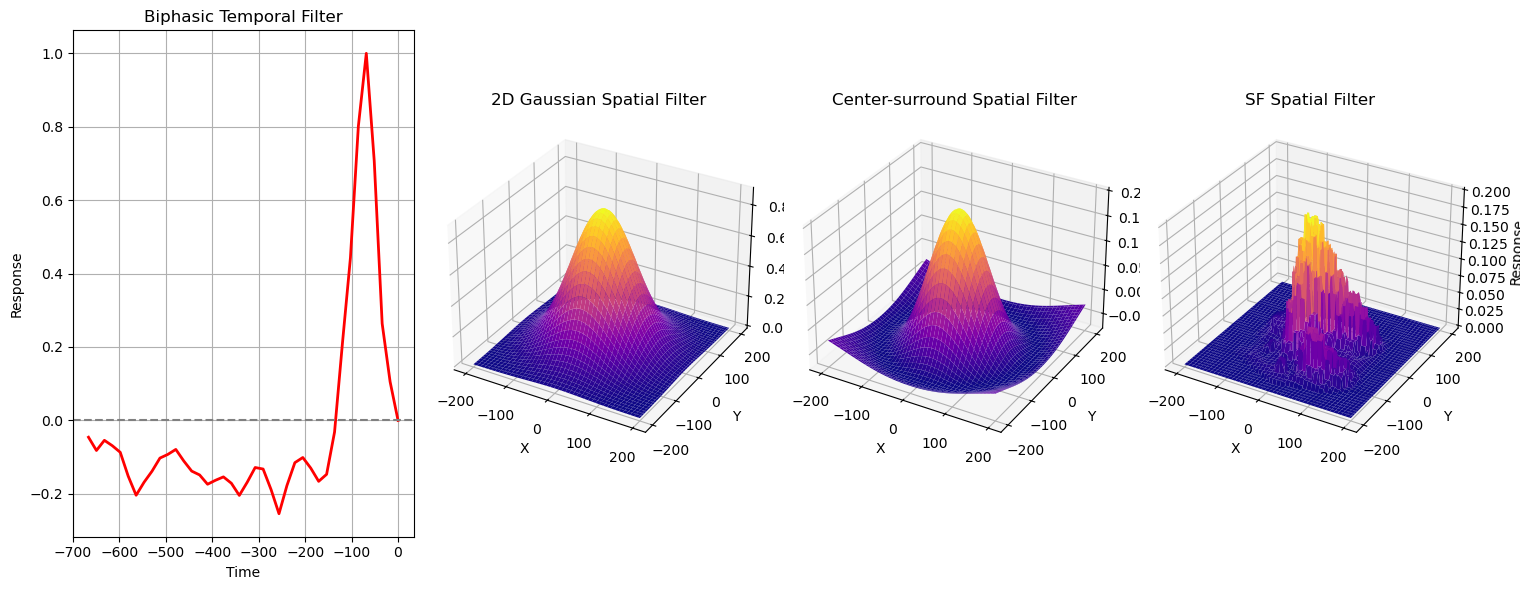

In [19]:
x_SF = np.linspace(-200, 200, 401).astype(int)
y_SF = np.linspace(-200, 200, 401).astype(int)
X_SF, Y_SF = np.meshgrid(x_SF, y_SF) 
spatial_rf1 = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y,A = A)
spatial_rf2 = difference_of_gaussians(x_SF, y_SF, sigma_c, sigma_s)
spatial_rf3 = spatial_filterSF(rf_estimated,A=0.2)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(141)
# ax1.plot(t_temporal, temp_rf, label=f'Temporal Filter', color='b', linewidth=2)
ax1.plot(t_temporalfitted,temporal_filter_noise, label=f'Reversed Temporal Filter', color='r', linewidth=2)
ax1.axhline(0, color='gray', linestyle='--')  # Add a reference horizontal line at 0
ax1.grid(True)
ax1.set_title('Biphasic Temporal Filter')
ax1.set_xlabel('Time')
ax1.set_ylabel('Response')


ax2 = fig.add_subplot(142, projection='3d')
ax2.plot_surface(X_SF,Y_SF, spatial_rf1, cmap='plasma')
ax2.set_title("2D Gaussian Spatial Filter")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Response')

ax3 = fig.add_subplot(143, projection='3d')
ax3.plot_surface(X_SF,Y_SF, spatial_rf2, cmap='plasma')
ax3.set_title("Center-surround Spatial Filter")
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Response')

ax4 = fig.add_subplot(144, projection='3d')
ax4.plot_surface(X_SF,Y_SF, spatial_rf3, cmap='plasma')
ax4.set_title("SF Spatial Filter")
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Response')
plt.tight_layout()
plt.show()

# NonLinear

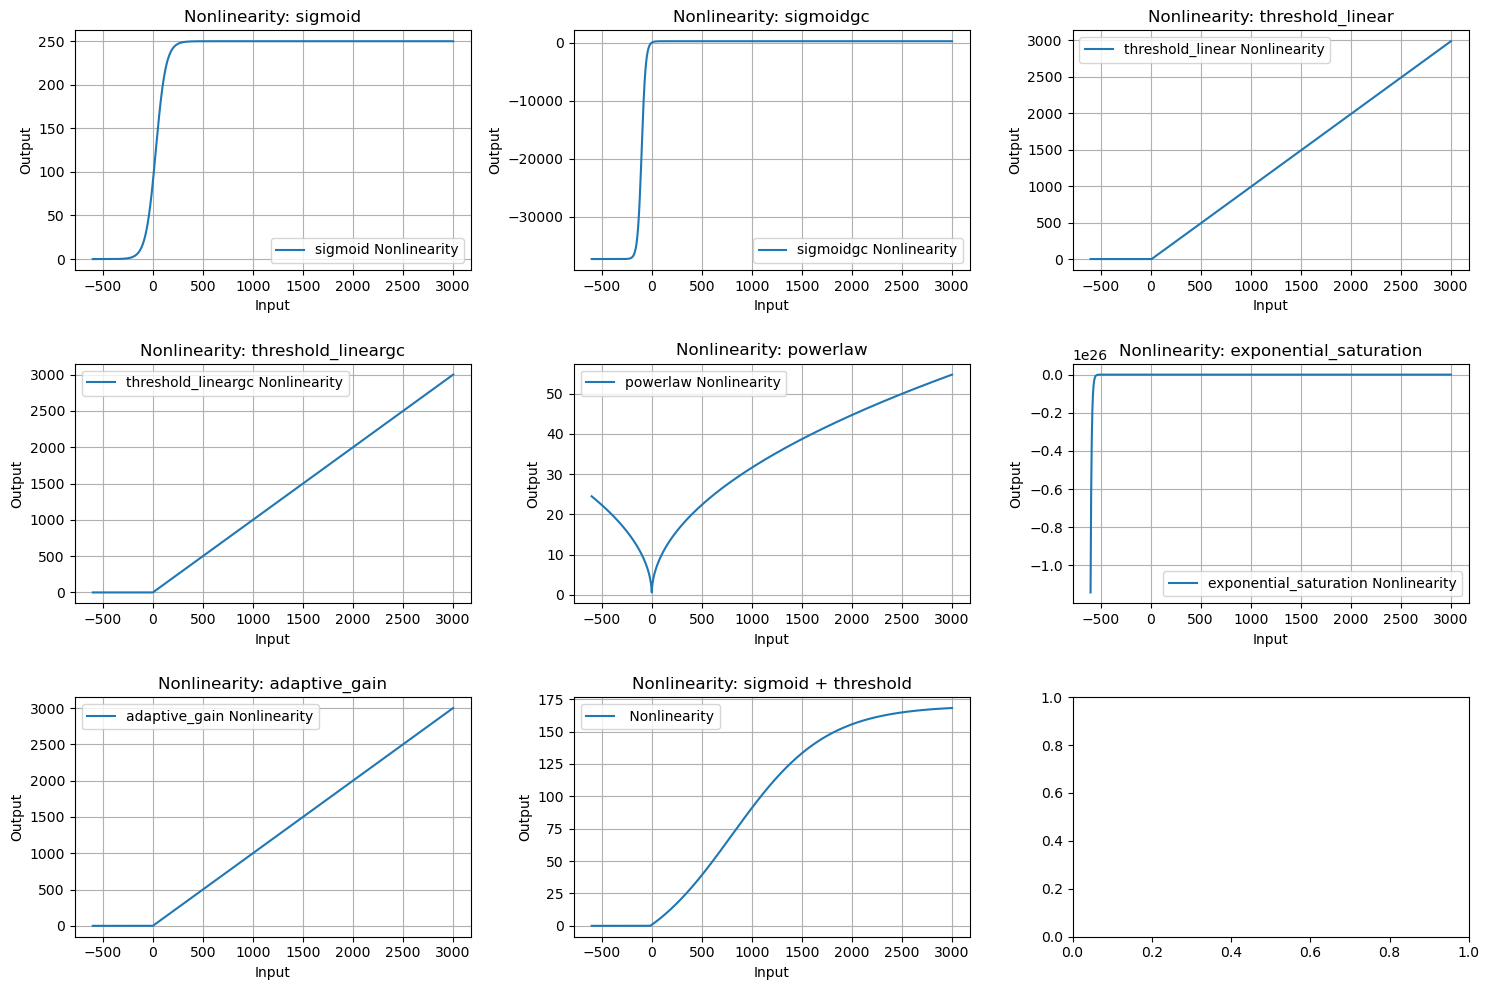

In [20]:
nonlinear_methods = [ 'sigmoid','sigmoidgc', 'threshold_linear','threshold_lineargc','powerlaw', 'exponential_saturation', 'adaptive_gain' ]
outputs = {}

tNN = np.linspace(-600, 3000, 1800)

tLN = apply_nonlinearity(apply_nonlinearity(tNN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = 30)

for method in nonlinear_methods:
    outputs[method] = apply_nonlinearity(tNN, method=method)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, method in enumerate(nonlinear_methods):
    axes[i].plot(tNN, outputs[method], label=f'{method} Nonlinearity')
    axes[i].set_title(f'Nonlinearity: {method}')
    axes[i].set_xlabel('Input')
    axes[i].set_ylabel('Output')
    axes[i].grid(True)
    axes[i].legend()

axes[7].plot(tNN, tLN, label=f' Nonlinearity')
axes[7].set_title(f'Nonlinearity: sigmoid + threshold')
axes[7].set_xlabel('Input')
axes[7].set_ylabel('Output')
axes[7].grid(True)
axes[7].legend()

plt.tight_layout()
plt.show()

# model output

In [21]:
# LN model
spike_trainLN = []
LoutLN = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s, stimuli, reversed_temp_rf, spatialtype,rf_estimated)
LNoutLN = apply_nonlinearity(apply_nonlinearity(LoutLN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)

time_bin = 1/time_para
for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutLN, time_bin))
    spike_trainLN.append(np.where(spikingindx > 0))


#LN model with gain control
spike_trainGC = []
LoutGC = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s, stimuli, reversed_temp_rf, spatialtype,rf_estimated)
LoutGC, g = gain_control(LoutGC, B, tau)
LNoutGC = apply_nonlinearity(apply_nonlinearity(LoutGC, 'sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)
time_bin = 1/time_para
for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutGC, time_bin))
    spike_trainGC.append(np.where(spikingindx > 0))

In [22]:
if spatialtype == 'gaussian':
    with open('spike_trainGC_g2.pkl', 'wb') as f:
        pickle.dump(spike_trainGC, f)
if spatialtype == 'SFfitting':
    with open('spike_trainGC.pkl', 'wb') as f:
        pickle.dump(spike_trainGC, f)

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_34472\2746344117.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


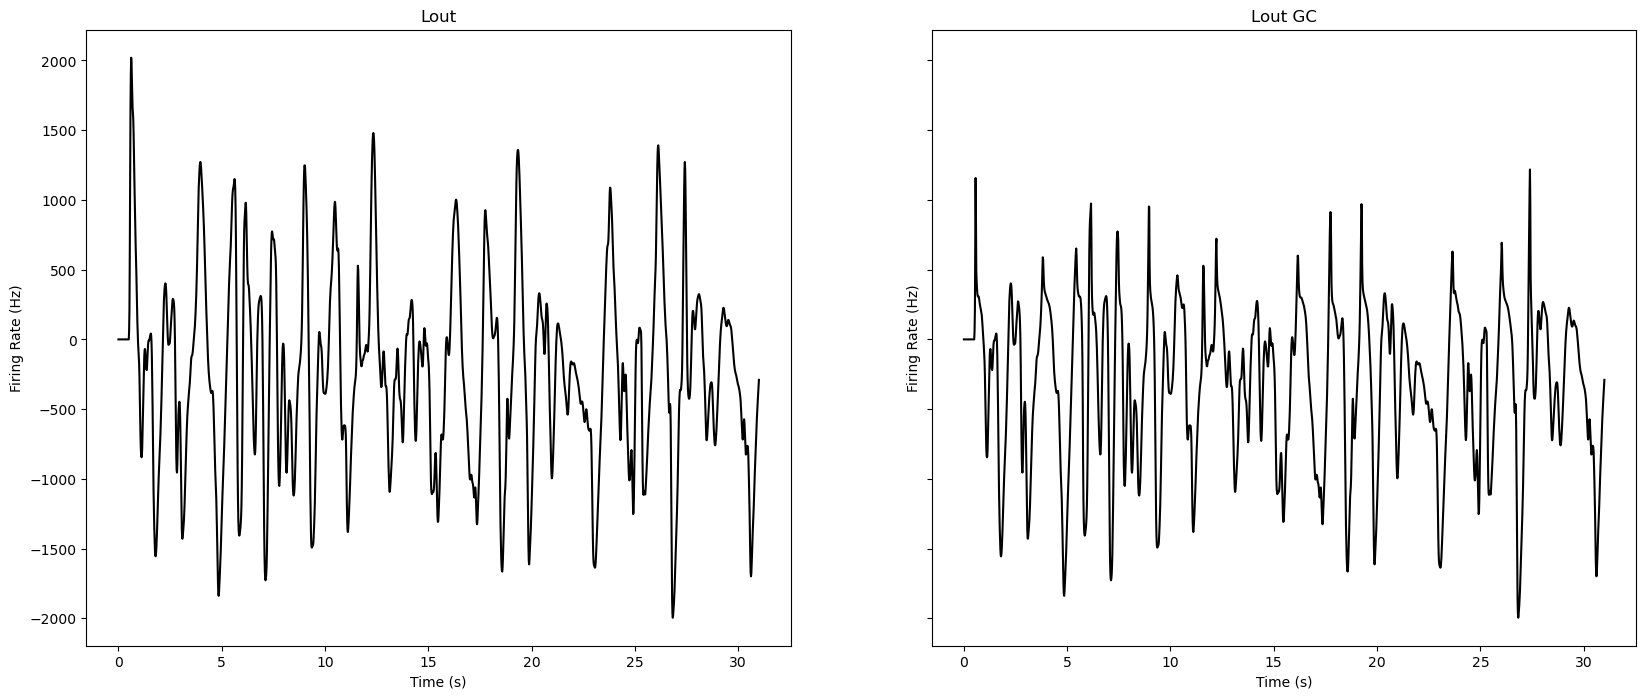

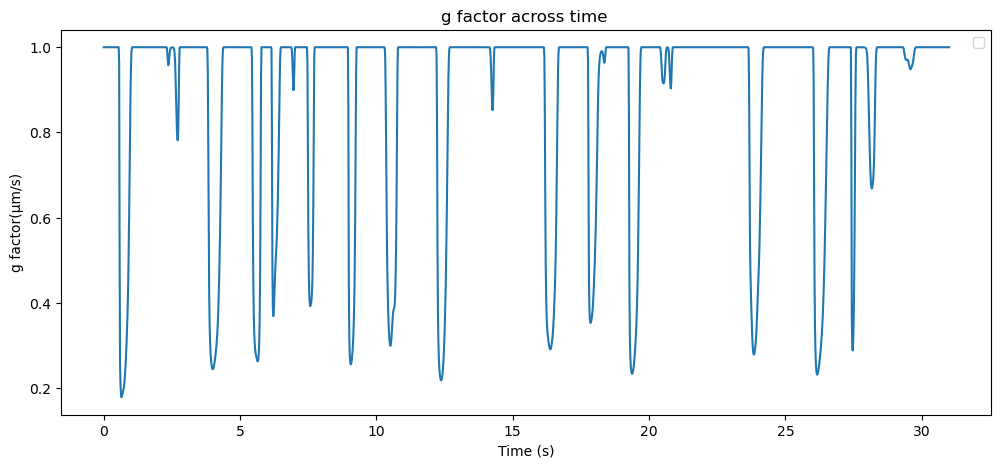

In [23]:
# Lout compare
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)
ax1.plot(t_sampling/60, LoutLN, 'k')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing Rate (Hz)')
ax1.set_title('Lout')

ax2.plot(t_sampling/60, LoutGC, 'k')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.set_title('Lout GC')

plt.figure(figsize=(12, 5))
plt.plot(t_sampling/60,g)
plt.xlabel('Time (s)')
plt.ylabel('g factor(μm/s)')
plt.title('g factor across time ')
plt.legend()

# spike raster model

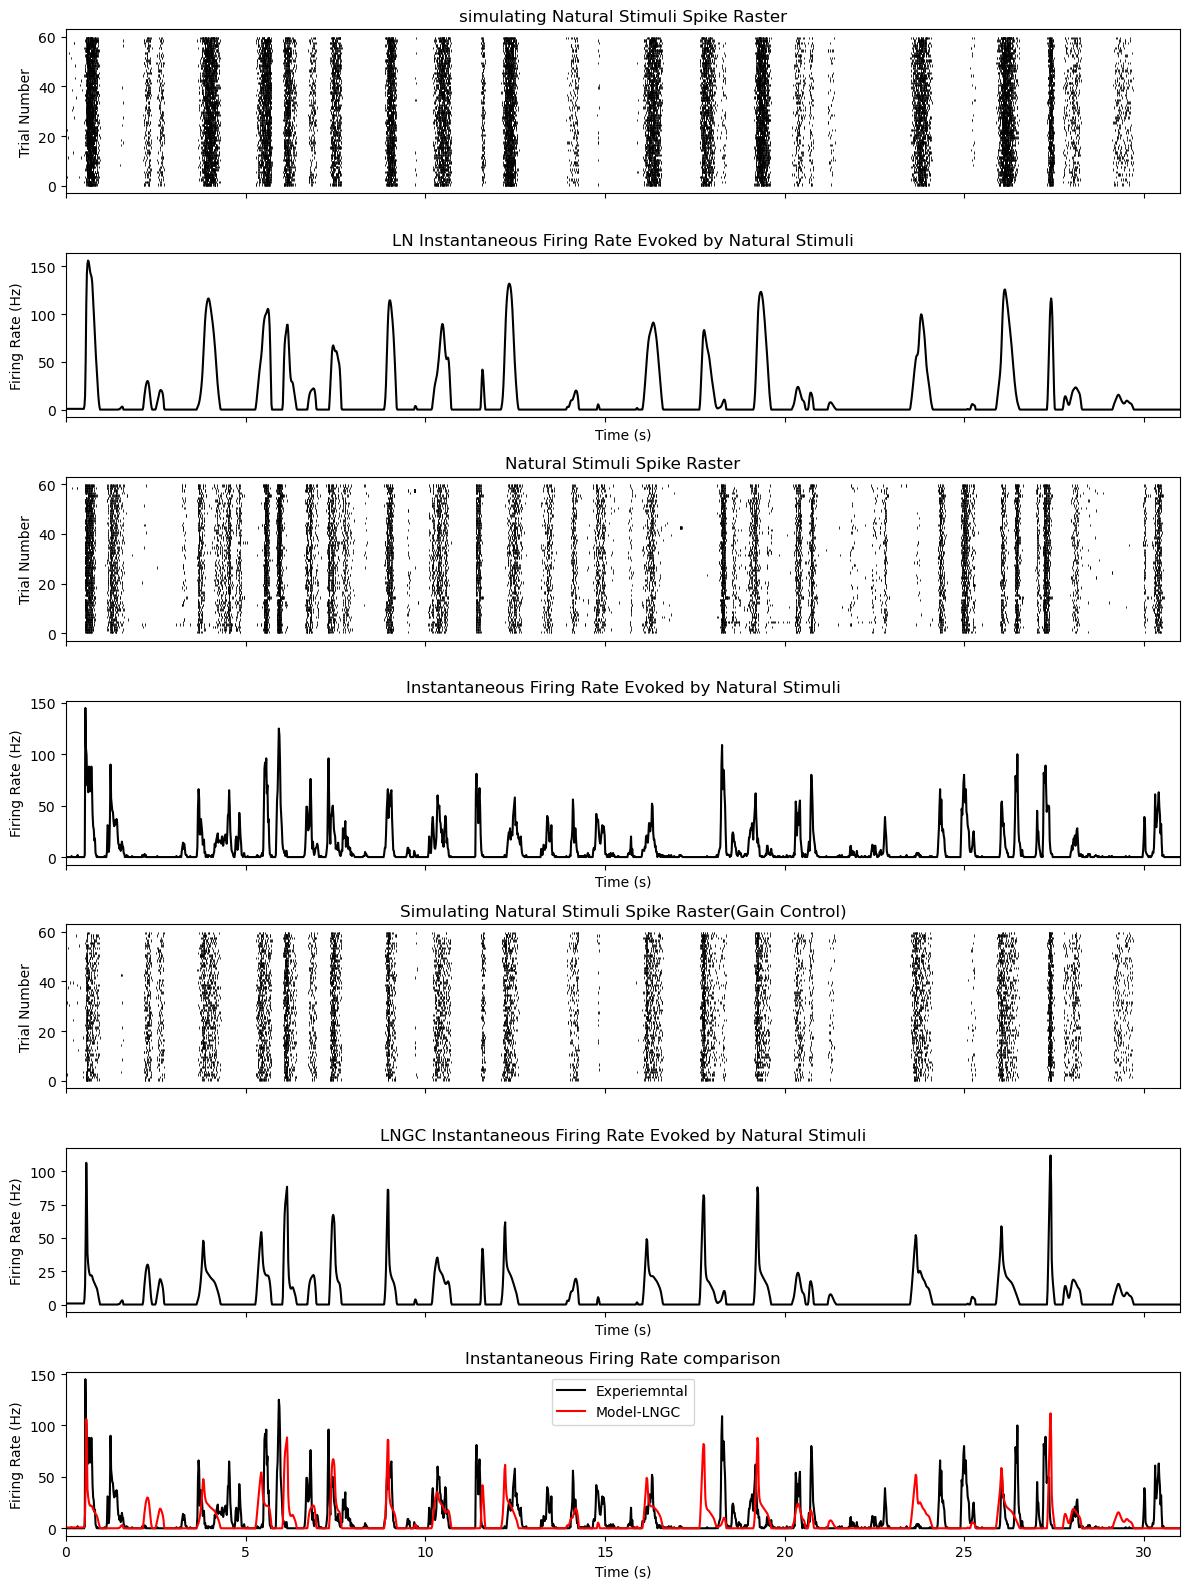

In [24]:
# model for test motion movie
if stimttype == 'movingobject':
    fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(6, 1, figsize=(12, 16), sharex=True)
    spike_t = spike_trainLN
    output_forrating = LNoutLN
    num_trials_modeln = len(spike_t)
    spikes_modeln = []
    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_t[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax1.set_ylabel('Trial Number')
    ax1.set_title('simulating Natural Stimuli Spike Raster')
    ax1.set_xlim(0, 1)  

    ax2.plot(t_sampling/60, output_forrating, 'k')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Firing Rate (Hz)')
    ax2.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli')

    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_trainGC[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax5.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax5.set_ylabel('Trial Number')
    ax5.set_title('Simulating Natural Stimuli Spike Raster(Gain Control)')
    ax5.set_xlim(0, 1)  

    ax6.plot(t_sampling/60, LNoutGC, 'k')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Firing Rate (Hz)')
    ax6.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli')



    spikes_M = []
    bin_width = 5 * minISI # s
    bins = np.arange(0, 1 + bin_width, bin_width) 
    spikes_in_trial = spike_indices_M[moving_trialidx] / 10000 - delay
    spikes_M.extend(spikes_in_trial)
    counts_M, bin_edges = np.histogram(spikes_M, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    num_trials_M = len(spike_indices_M)



    ax3.vlines(spikes_in_trial, 1, 1 + 1, 'k', linewidth=0.6)
    ax3.set_ylabel('Trial Number')
    ax3.set_title('Natural Stimuli Spike Raster')
    ax3.set_xlim(0, 1)  

    average_spike_count_M = counts_M / num_trials_M
    firing_rate_M = average_spike_count_M / bin_width

    ax4.plot(bin_centers, firing_rate_M, 'k')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Firing Rate (Hz)')
    ax4.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli')

    plt.tight_layout()
    plt.show()
else:
    # plot for model and gain control stimuli

    fig, (ax1, ax2, ax3, ax4, ax5,ax6,ax7) = plt.subplots(7, 1, figsize=(12, 16), sharex=True)

    spike_t = spike_trainLN
    output_forrating = LNoutLN
    num_trials_modeln = len(spike_t)
    spikes_modeln = []
    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_t[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax1.set_ylabel('Trial Number')
    ax1.set_title('simulating Natural Stimuli Spike Raster')
    ax1.set_xlim(0, 31)  

    ax2.plot(t_sampling/60, output_forrating, 'k')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Firing Rate (Hz)')
    ax2.set_title('LN Instantaneous Firing Rate Evoked by Natural Stimuli')

    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_trainGC[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax5.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax5.set_ylabel('Trial Number')
    ax5.set_title('Simulating Natural Stimuli Spike Raster(Gain Control)')
    ax5.set_xlim(0, 31)  

    ax6.plot(t_sampling/60, LNoutGC, 'k')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Firing Rate (Hz)')
    ax6.set_title('LNGC Instantaneous Firing Rate Evoked by Natural Stimuli')

    # bin_width = 5 * minISI # s
    bin_width = 1/60 # s
    bins = np.arange(0, 31 + bin_width, bin_width) 
    counts_n, bin_edges = np.histogram(spikes_n, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    num_trials_n = len(spike_indices_n)
    spikes_n = []
    for spike_idx_n in range(num_trials_n):
        spikes_in_trial = spike_indices_n[spike_idx_n] / 10000 - delay
        spikes_n.extend(spikes_in_trial)
        ax3.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax3.set_ylabel('Trial Number')
    ax3.set_title('Natural Stimuli Spike Raster')
    ax3.set_xlim(0, 31)  

    average_spike_count_n = counts_n / num_trials_n
    firing_rate_n = average_spike_count_n / bin_width

    ax4.plot(bin_centers, firing_rate_n, 'k')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Firing Rate (Hz)')
    ax4.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli')

    ax7.plot(bin_centers, firing_rate_n, 'k',label='Experiemntal')
    ax7.plot(t_sampling/60, LNoutGC, 'r',label='Model-LNGC')
    # ax7.plot(t_sampling/60, LNoutLN, 'b',label='Model-LN')
    ax7.set_xlabel('Time (s)')
    ax7.set_ylabel('Firing Rate (Hz)')
    ax7.set_title('Instantaneous Firing Rate comparison')
    ax7.legend()
    plt.tight_layout()
    plt.show()


# STA for model output

In [25]:
d_n_model_LN = np.zeros((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])))

sta_v_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_a_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_x_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_y_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_r_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)



for trial_idx, spikes in enumerate(spike_trainLN):

    spike_indices = (spikes[0].flatten() / time_para / dt ).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n_model_LN[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n_model_LN[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] += 1



sta_v_n_model_LN /= d_n_model_LN
sta_a_n_model_LN /= d_n_model_LN
sta_x_n_model_LN /= d_n_model_LN
sta_y_n_model_LN /= d_n_model_LN
sta_r_n_model_LN /= d_n_model_LN



avg_sta_v_n_model_LN = np.nanmean(sta_v_n_model_LN, axis=(1, 2))
avg_sta_a_n_model_LN = np.nanmean(sta_a_n_model_LN, axis=(1, 2))
avg_sta_x_n_model_LN = np.nanmean(sta_x_n_model_LN, axis=(1, 2))
avg_sta_y_n_model_LN = np.nanmean(sta_y_n_model_LN, axis=(1, 2))
avg_sta_r_n_model_LN = np.nanmean(sta_r_n_model_LN, axis=(1, 2))

In [26]:
d_n_model_GC = np.zeros((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])))

sta_v_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_a_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_x_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_y_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_r_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)



for trial_idx, spikes in enumerate(spike_trainGC):

    spike_indices = (spikes[0].flatten() / time_para / dt ).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n_model_GC[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n_model_GC[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] += 1



sta_v_n_model_GC /= d_n_model_GC
sta_a_n_model_GC /= d_n_model_GC
sta_x_n_model_GC /= d_n_model_GC
sta_y_n_model_GC /= d_n_model_GC
sta_r_n_model_GC /= d_n_model_GC



avg_sta_v_n_model_GC = np.nanmean(sta_v_n_model_GC, axis=(1, 2))
avg_sta_a_n_model_GC = np.nanmean(sta_a_n_model_GC, axis=(1, 2))
avg_sta_x_n_model_GC = np.nanmean(sta_x_n_model_GC, axis=(1, 2))
avg_sta_y_n_model_GC = np.nanmean(sta_y_n_model_GC, axis=(1, 2))
avg_sta_r_n_model_GC = np.nanmean(sta_r_n_model_GC, axis=(1, 2))

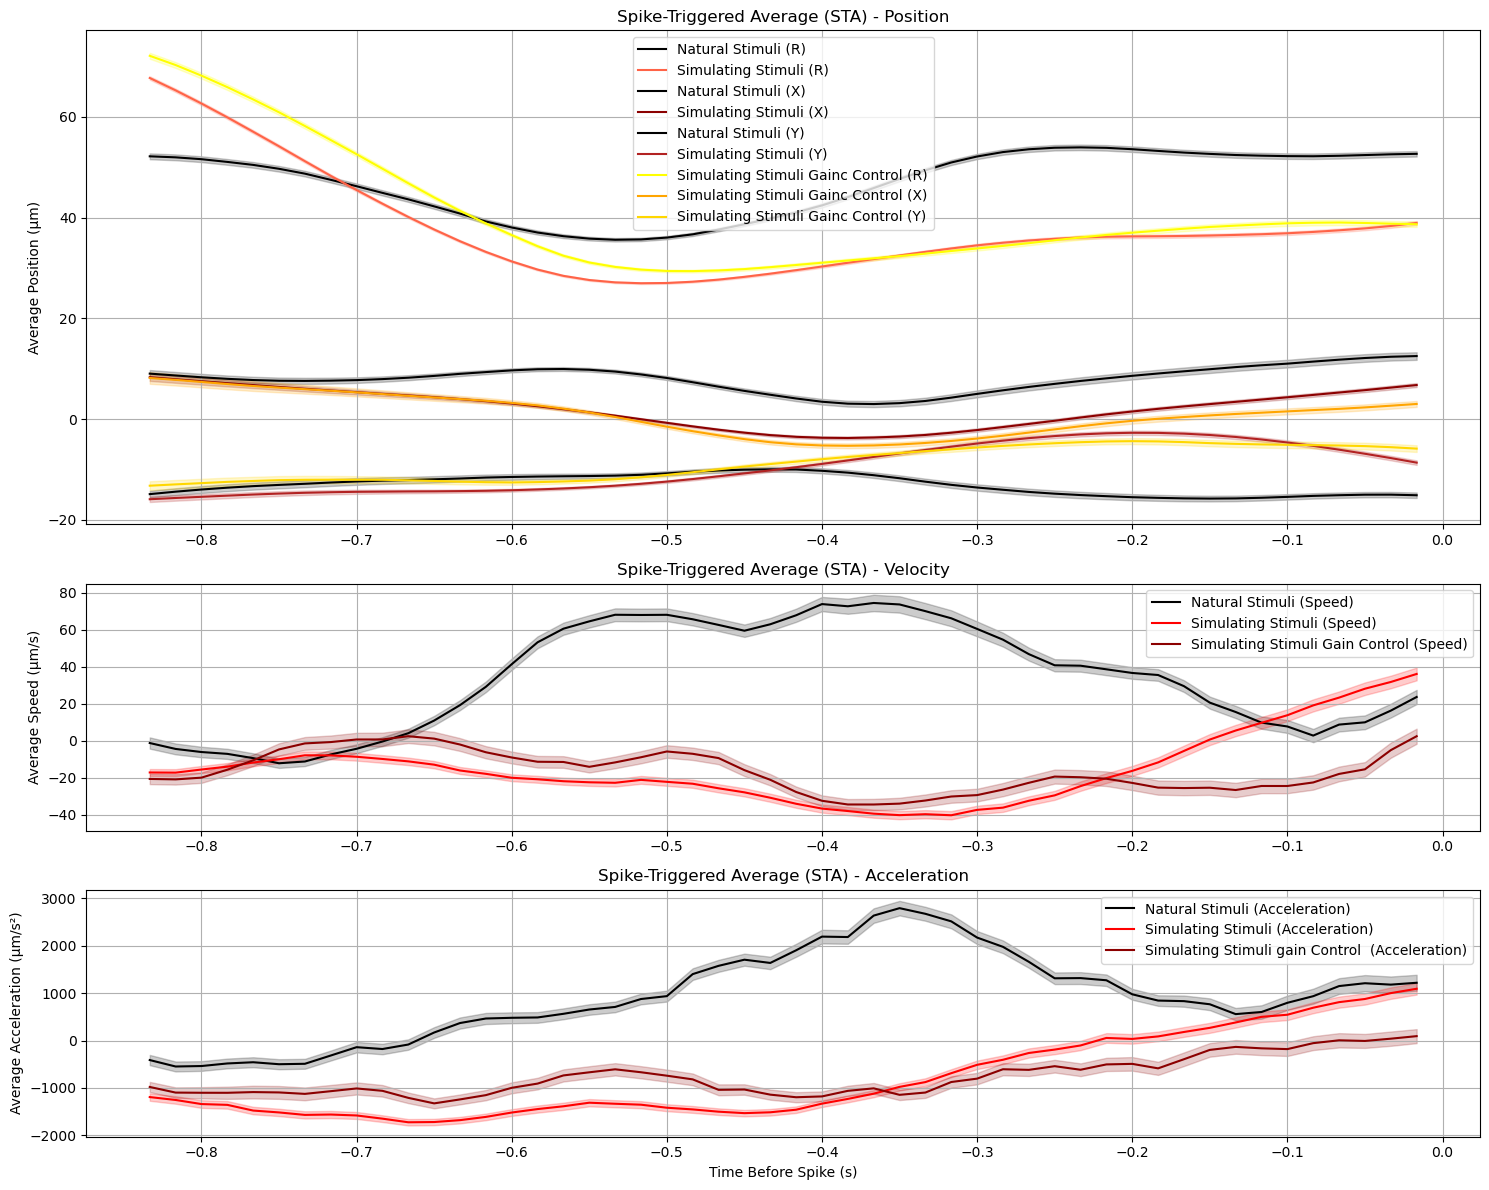

In [27]:

# Plot STA for velocity and acceleration
time_window = np.linspace(-T * dt, -dt, T)

sem_x_n_model_LN = np.nanstd(sta_x_n_model_LN.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_LN, axis=(1,2)))
sem_y_n_model_LN = np.nanstd(sta_y_n_model_LN.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_LN, axis=(1,2)))
sem_r_n_model_LN = np.nanstd(sta_r_n_model_LN.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_LN, axis=(1,2)))
sem_v_n_model_LN = np.nanstd(sta_v_n_model_LN.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_LN, axis=(1,2)))
sem_a_n_model_LN = np.nanstd(sta_a_n_model_LN.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_LN, axis=(1,2)))
sem_x_n_model_GC = np.nanstd(sta_x_n_model_GC.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_GC, axis=(1,2)))
sem_y_n_model_GC = np.nanstd(sta_y_n_model_GC.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_GC, axis=(1,2)))
sem_r_n_model_GC = np.nanstd(sta_r_n_model_GC.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_GC, axis=(1,2)))
sem_v_n_model_GC = np.nanstd(sta_v_n_model_GC.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_GC, axis=(1,2)))
sem_a_n_model_GC = np.nanstd(sta_a_n_model_GC.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n_model_GC, axis=(1,2)))



# Define the GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])  


ax1 = fig.add_subplot(gs[0])
ax1.plot(time_window, avg_sta_r_n, label='Natural Stimuli (R)', color='k')
ax1.fill_between(time_window, avg_sta_r_n - 2 * sem_r_n, avg_sta_r_n + 2 * sem_r_n, color='k', alpha=0.2)
ax1.plot(time_window, avg_sta_r_n_model_LN, label='Simulating Stimuli (R)', color='tomato')
ax1.fill_between(time_window, avg_sta_r_n_model_LN - 2 * sem_r_n_model_LN, avg_sta_r_n_model_LN + 2 * sem_r_n_model_LN, color='tomato', alpha=0.2)
ax1.plot(time_window, avg_sta_x_n, label='Natural Stimuli (X)', color='k')
ax1.fill_between(time_window, avg_sta_x_n - 2 * sem_x_n, avg_sta_x_n + 2 * sem_x_n, color='k', alpha=0.2)
ax1.plot(time_window, avg_sta_x_n_model_LN, label='Simulating Stimuli (X)', color='darkred')
ax1.fill_between(time_window, avg_sta_x_n_model_LN - 2 * sem_x_n_model_LN, avg_sta_x_n_model_LN + 2 * sem_x_n_model_LN, color='darkred', alpha=0.2)
ax1.plot(time_window, avg_sta_y_n, label='Natural Stimuli (Y)', color='k')
ax1.fill_between(time_window, avg_sta_y_n - 2 * sem_y_n, avg_sta_y_n + 2 * sem_y_n, color='k', alpha=0.2)
ax1.plot(time_window, avg_sta_y_n_model_LN, label='Simulating Stimuli (Y)', color='firebrick')
ax1.fill_between(time_window, avg_sta_y_n_model_LN - 2 * sem_y_n_model_LN, avg_sta_y_n_model_LN + 2 * sem_y_n_model_LN, color='firebrick', alpha=0.2)

ax1.plot(time_window, avg_sta_r_n_model_GC, label='Simulating Stimuli Gainc Control (R)', color='yellow')
ax1.fill_between(time_window, avg_sta_r_n_model_GC - 2 * sem_r_n_model_GC, avg_sta_r_n_model_GC + 2 * sem_r_n_model_GC, color='yellow', alpha=0.2)

ax1.plot(time_window, avg_sta_x_n_model_GC, label='Simulating Stimuli Gainc Control (X)', color='orange')
ax1.fill_between(time_window, avg_sta_x_n_model_GC - 2 * sem_x_n_model_GC, avg_sta_x_n_model_GC + 2 * sem_x_n_model_GC, color='orange', alpha=0.2)

ax1.plot(time_window, avg_sta_y_n_model_GC, label='Simulating Stimuli Gainc Control (Y)', color='gold')
ax1.fill_between(time_window, avg_sta_y_n_model_GC - 2 * sem_y_n_model_GC, avg_sta_y_n_model_GC + 2 * sem_y_n_model_GC, color='gold', alpha=0.2)

ax1.set_ylabel('Average Position (μm)')
ax1.set_title('Spike-Triggered Average (STA) - Position')
ax1.legend()
ax1.grid(True)

# Velocity
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Share x-axis with the first plot
ax2.plot(time_window, avg_sta_v_n, label='Natural Stimuli (Speed)', color='k')
ax2.fill_between(time_window, avg_sta_v_n - 2 * sem_v_n, avg_sta_v_n + 2 * sem_v_n, color='k', alpha=0.2)
ax2.plot(time_window, avg_sta_v_n_model_LN, label='Simulating Stimuli (Speed)', color='red')
ax2.fill_between(time_window, avg_sta_v_n_model_LN - 2 * sem_v_n_model_LN, avg_sta_v_n_model_LN + 2 * sem_v_n_model_LN, color='red', alpha=0.2)
ax2.plot(time_window, avg_sta_v_n_model_GC, label='Simulating Stimuli Gain Control (Speed)', color='darkred')
ax2.fill_between(time_window, avg_sta_v_n_model_GC - 2 * sem_v_n_model_GC, avg_sta_v_n_model_GC + 2 * sem_v_n_model_GC, color='darkred', alpha=0.2)
ax2.set_ylabel('Average Speed (μm/s)')
ax2.set_title('Spike-Triggered Average (STA) - Velocity')
ax2.legend()
ax2.grid(True)

# Acceleration
ax3 = fig.add_subplot(gs[2], sharex=ax1)  # Share x-axis with the first plot
ax3.plot(time_window, avg_sta_a_n, label='Natural Stimuli (Acceleration)', color='k')
ax3.fill_between(time_window, avg_sta_a_n - 2 * sem_a_n, avg_sta_a_n + 2 * sem_a_n, color='k', alpha=0.2)
ax3.plot(time_window, avg_sta_a_n_model_LN, label='Simulating Stimuli (Acceleration)', color='red')
ax3.fill_between(time_window, avg_sta_a_n_model_LN - 2 * sem_a_n_model_LN, avg_sta_a_n_model_LN + 2 * sem_a_n_model_LN, color='red', alpha=0.2)
ax3.plot(time_window, avg_sta_a_n_model_GC, label='Simulating Stimuli gain Control  (Acceleration)', color='darkred')
ax3.fill_between(time_window, avg_sta_a_n_model_GC - 2 * sem_a_n_model_GC, avg_sta_a_n_model_GC + 2 * sem_a_n_model_GC, color='darkred', alpha=0.2)
ax3.set_xlabel('Time Before Spike (s)')
ax3.set_ylabel('Average Acceleration (μm/s²)')
ax3.set_title('Spike-Triggered Average (STA) - Acceleration')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()